In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import resample_to_delta_t, matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr

In [11]:
def get_conditioned(data):
    data = data.highpass_fir(15, 512)
    data = resample_to_delta_t(data, 1.0/2048).crop(2, 2)
    return data

data = {}
data['H1'] = read_frame("challenge3.gwf", "H1:CHALLENGE3")
data['L1'] = read_frame("challenge3.gwf", "L1:CHALLENGE3")
data['H1'] = get_conditioned(data['H1'])
data['L1'] = get_conditioned(data['L1'])

In [7]:
def get_template(cmass, size, delta_f, approximant="IMRPhenomD"):
    hp, _ = get_fd_waveform(
                    approximant=approximant,
                    mass1=cmass,
                    mass2=cmass,
                    delta_f=delta_f,
                    f_lower=20)
    hp.resize(size)
    return hp

def get_psd(data):
    psd = data.psd(4)
    psd = interpolate(psd, data.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * data.sample_rate),
                                      low_frequency_cutoff=15)
    return psd

def get_snr(template, data, psd):
    snr = matched_filter(template, data, psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(4, 4)
    return snr

def get_snr_peak(snr):
    idx = np.argmax(abs(snr))
    time = snr.sample_times[idx]
    snrp = abs(snr.data[idx])
    return snrp, time

def get_chisq(template, data, psd, nbins=26):
    chisq = power_chisq(template, data, nbins, psd, low_frequency_cutoff=20)
    chisq = chisq.crop(5, 4)
    chisq /= nbins * 2 - 2
    return chisq

In [12]:
psd = {}
psd['H1'] = get_psd(data['H1'])
psd['L1'] = get_psd(data['L1'])

In [19]:
def get_snr_and_nsnr_from_cmass(cmass, data, psd):
    template = get_template(cmass, size=len(psd), delta_f=data.delta_f)
    snr = get_snr(template, data, psd)
    chisq = get_chisq(template, data, psd)
    nsnr = newsnr(abs(snr), chisq)
    return snr, nsnr

def plot_nsnr_for_cmass(cmass, data, psd, ifos=['H1', 'L1']):
    fig, axes = plt.subplots(len(ifos), 1, figsize=(10, 3*len(ifos)))
    for i, k in enumerate(ifos):
        snr, nsnr = get_snr_and_nsnr_from_cmass(cmass, data[k], psd[k])
        axes[i].plot(snr.sample_times, nsnr, c=f'C{i}', label=f"{k} SNR (reweighted)")
        axes[i].legend()
        axes[i].grid()
    fig.suptitle(f"m1 = m2 = {cmass}")
    return fig

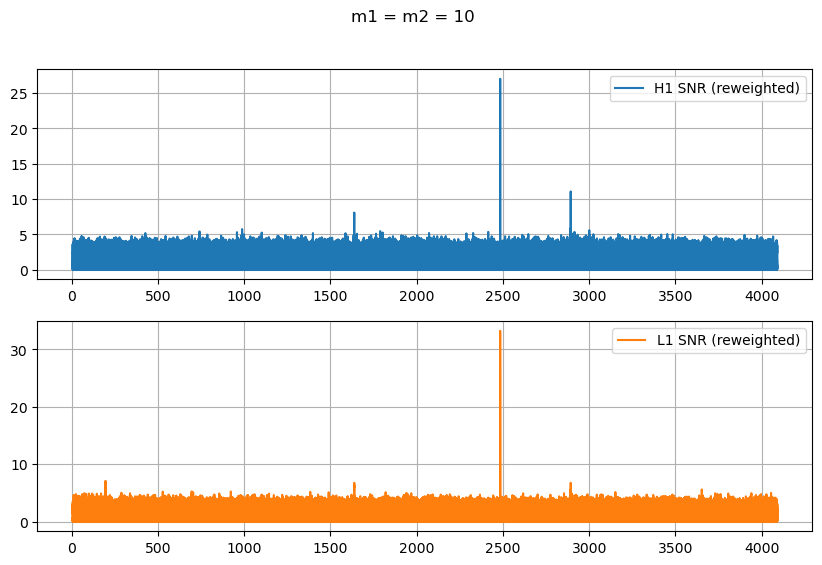

In [21]:
_ = plot_nsnr_for_cmass(10, data, psd)

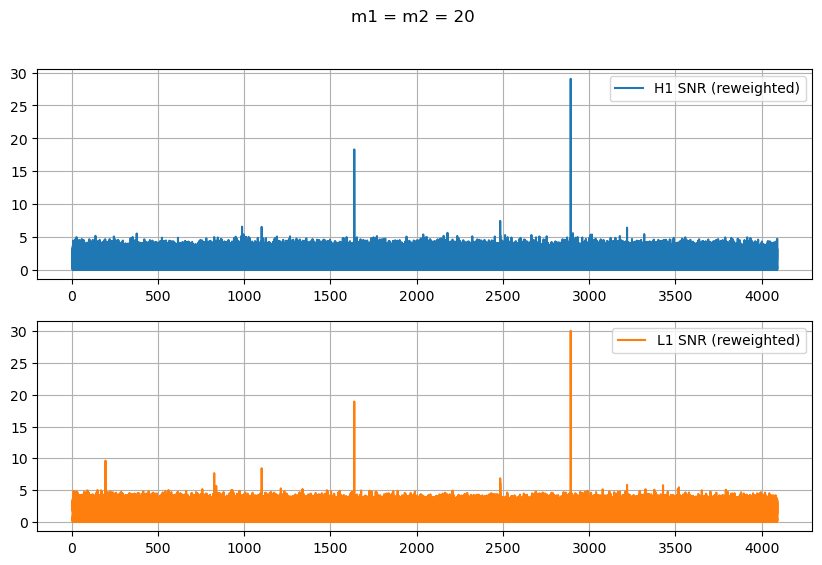

In [22]:
_ = plot_nsnr_for_cmass(20, data, psd)

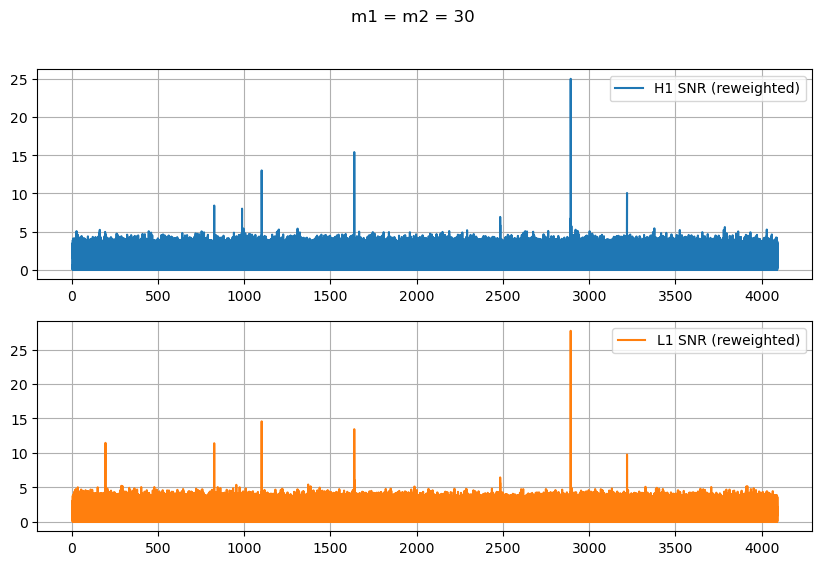

In [23]:
_ = plot_nsnr_for_cmass(30, data, psd)

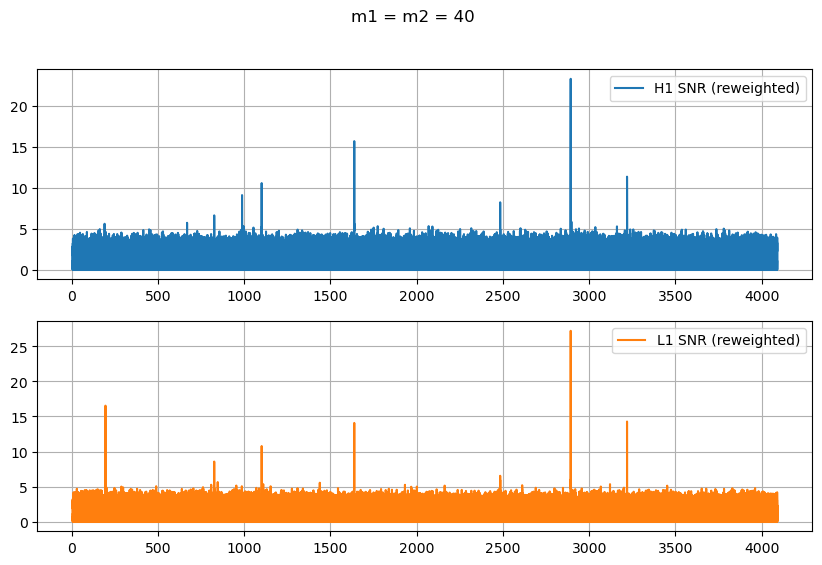

In [24]:
_ = plot_nsnr_for_cmass(40, data, psd)

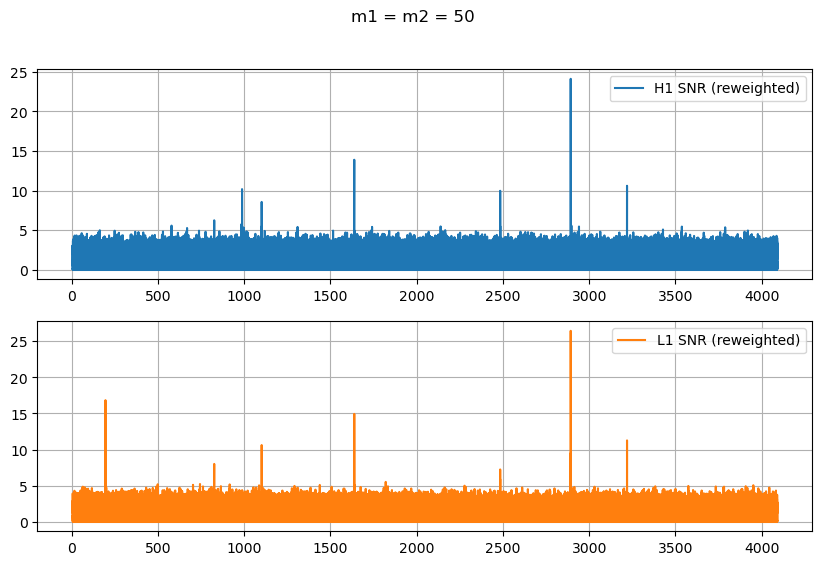

In [25]:
_ = plot_nsnr_for_cmass(50, data, psd)

## Possible signals:

1. t = 200, cmass = 45, H1 snr = 17, L1 not shown
2. t = 800, cmass = 30, H1 snr = 8, L1 snr = 12
3. t = 1000, cmass = 50, H1 snr = 10, L1 not shown
4. t = 1100, cmass = 30, H1 snr = 13, L1 snr = 15
5. t = 1650, cmass = 20, H1 snr = 18, L1 snr = 19
6. t = 2500, cmass = 10, H1 snr = 26, L1 snr = 33
7. t = 2850, cmass = 20, H1 snr = 29, L1 snr = 30
8. t = 3200, cmass = 40, H1 snr = 12, L1 snr = 15